# Load Dependencies and Check GPU Status

In [1]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
import numpy as np

# check if GPU is recognized
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Build Dataloading Function

In [2]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

### Plot Wave

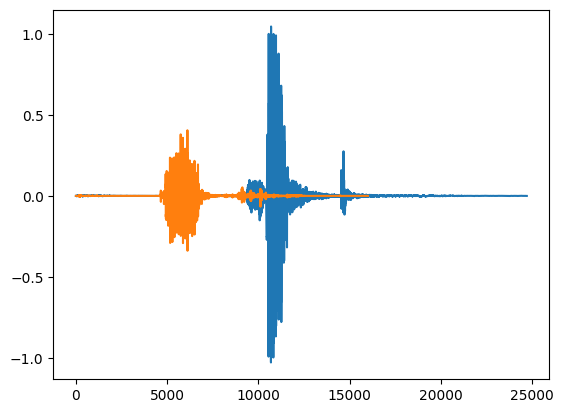

In [3]:
# raw data
BAD_FILE = os.path.join("C:/Users/jreye/ML_DATA/BadWords/fuck/fuck1.wav")
NOT_BAD_FILE = os.path.join("C:/Users/jreye/ML_DATA/NotBadWords/NotBad_comp/backward(1).wav")

wave = load_wav_16k_mono(BAD_FILE)
nwave = load_wav_16k_mono(NOT_BAD_FILE)

plt.plot(wave)
plt.plot(nwave)
plt.show()

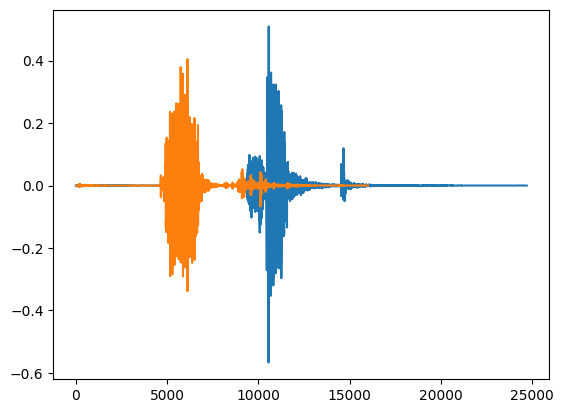

In [4]:
# normalized data
BAD_FILE = os.path.join("C:/Users/jreye/ML_DATA/BadWords/fuck_comp_all/fuck1.wav")
NOT_BAD_FILE = os.path.join("C:/Users/jreye/ML_DATA/NotBadWords/NotBad_comp/backward(1).wav")

wave = load_wav_16k_mono(BAD_FILE)
nwave = load_wav_16k_mono(NOT_BAD_FILE)

plt.plot(wave)
plt.plot(nwave)
plt.show()

# Create TensorFlow Dataset

In [5]:
# define paths to positive and negative data
NOT_BAD = os.path.join("C:/Users/jreye/ML_DATA/NotBadWords/NotBad_comp") 
FUCK = os.path.join("C:/Users/jreye/ML_DATA/BadWords/fuck_comp_all_44k") 
SHIT = os.path.join("C:/Users/jreye/ML_DATA/BadWords/shit_comp_all") 

# Create multi-classification datasets
not_bad = tf.data.Dataset.list_files(NOT_BAD+'\*.wav').map(lambda x: (x, tf.constant([1, 0, 0], dtype=tf.float32))) 
fuck = tf.data.Dataset.list_files(FUCK+'\*.wav').map(lambda x: (x, tf.constant([0, 1, 0], dtype=tf.float32))) 
shit = tf.data.Dataset.list_files(SHIT+'\*.wav').map(lambda x: (x, tf.constant([0, 0, 1], dtype=tf.float32))) 

data = not_bad.concatenate(fuck)
data = data.concatenate(shit)

# for debugging
#list(fuck.as_numpy_iterator())

## Determine Average Length of Sample

In [6]:
# calculate wave cycle length
lengths = []

# not bad files
# for file in os.listdir(os.path.join(NOT_BAD)):
#     tensor_wave = load_wav_16k_mono(os.path.join(NOT_BAD, file))
#     lengths.append(len(tensor_wave))

# # fuck 
# for file in os.listdir(os.path.join(FUCK)):
#     tensor_wave = load_wav_16k_mono(os.path.join(FUCK, file))
#     lengths.append(len(tensor_wave))
    
# # shit
# for file in os.listdir(os.path.join(SHIT)):
#     tensor_wave = load_wav_16k_mono(os.path.join(SHIT, file))
#     lengths.append(len(tensor_wave))

In [7]:
# calculate mean
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=float32, numpy=nan>

In [8]:
# calculate min
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=float32, numpy=inf>

In [9]:
# calculate max
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=float32, numpy=-inf>

In [10]:
# ave length of bad word
tf.math.reduce_mean(lengths)/16000

<tf.Tensor: shape=(), dtype=float32, numpy=nan>

In [11]:
# min length of bad word
tf.math.reduce_min(lengths)/16000

<tf.Tensor: shape=(), dtype=float32, numpy=inf>

In [12]:
# max length of bad word
tf.math.reduce_max(lengths)/16000

<tf.Tensor: shape=(), dtype=float32, numpy=-inf>

# Build Preprocessing Function to Convert to Spectrogram

In [13]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:35000] # 35000 sample length (can make smaller to reduce processing time but will affect accuracy)
    zero_padding = tf.zeros([35000] - tf.shape(wav), dtype=tf.float32) 
    wav = tf.concat([zero_padding, wav],0) # pad clips longer than 25000 samples wiht zeros
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

[0. 0. 1.]


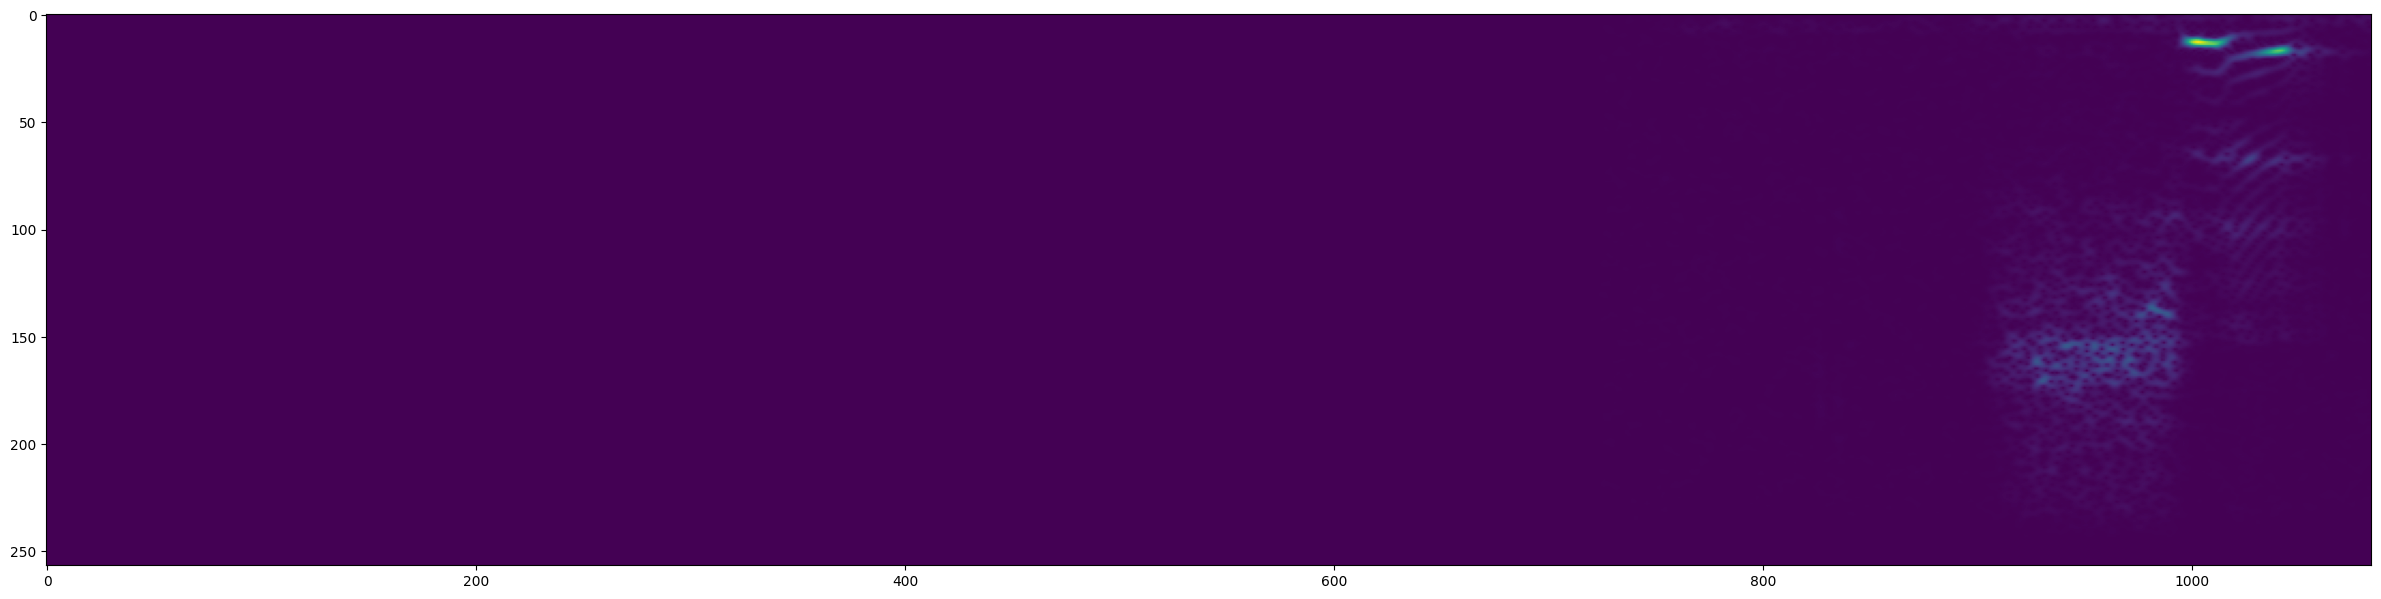

In [14]:
# test out the function and visualize the spectrogram (bad words)
# print from shit label
filepath, label = shit.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)
print(label)
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

# Create Training and Testing Partitions

In [15]:
len(data)

5190

In [16]:
# create TensorFlow data pipeline
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

In [17]:
len(data)

325

In [18]:
len(data)*.7

227.49999999999997

In [19]:
len(data) - len(data)*.7

97.50000000000003

In [20]:
# split into training and testing partitions
train = data.take(227) # 70 % goes to train set
test = data.skip(227).take(98) # 30 % goes to test set

In [21]:
train = train.shuffle(buffer_size=1000)
test = test.shuffle(buffer_size=1000)

# test one batch
samples, labels = train.as_numpy_iterator().next()

In [22]:
samples.shape

(16, 1084, 257, 1)

In [23]:
labels

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

# Build Deep Learning Model

In [24]:
# load Keras Model dependencies
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Activation, Dropout, LayerNormalization, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard # to view statistics
from tensorflow.keras.optimizers import SGD, Adam
import time

# Training Various Configurations of Model

In [25]:
# test various configs of model
dense_layers = [1] # 1 worked well so we check 0 and 2
layer_sizes = [32] # 16 worked well so we check 8 and 32
conv_layers = [2] # 2 worked well so we check 1 and 3
dense_size = 128

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME = "{}-conv-{}-nodes-{}-dense-{}".format(conv_layer, layer_size, dense_layer, int(time.time()))
            print(NAME)

            # create layers
            model = Sequential() 
            model.add(Conv2D(layer_size, (3,3), input_shape= (1084, 257, 1))) # depends on shape of spec
            model.add(LayerNormalization())
            model.add(Activation("relu"))
            model.add(MaxPooling2D(pool_size=(2,2)))

            for l in range(conv_layer-1):
                model.add(Conv2D(layer_size, (3,3)))
                model.add(LayerNormalization())
                model.add(Activation("relu"))
                model.add(Dropout(0.2))
                model.add(MaxPooling2D(pool_size=(2,2)))

            model.add(Flatten())
            for l in range(dense_layer):                                                                                            
                model.add(Dense(dense_size))
                model.add(Activation("relu"))

            # output layer
            model.add(Dense(3))
            model.add(Activation("softmax"))  

            tensorboard = TensorBoard(log_dir='bad_mouth_logs/{}'.format(NAME))

            model.compile(optimizer=Adam(learning_rate=0.001), # adam optimizer with a small learning rate
                          loss='CategoricalCrossentropy', 
                          metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision(), tf.keras.metrics.Accuracy()])

            # tensorboard analysis
            hist = model.fit(train, epochs=10, validation_data=test, callbacks = [tensorboard])

2-conv-32-nodes-1-dense-1680752772
Epoch 1/10
227/227 [==============================] - 121s 463ms/step - loss: 26.4704 - recall: 0.8309 - precision: 0.8323 - accuracy: 0.6654 - val_loss: 18.5135 - val_recall: 0.7041 - val_precision: 0.7041 - val_accuracy: 0.2257
Epoch 2/10
227/227 [==============================] - 94s 409ms/step - loss: 0.3294 - recall: 0.9146 - precision: 0.9162 - accuracy: 0.1221 - val_loss: 11.7472 - val_recall: 0.3338 - val_precision: 0.3338 - val_accuracy: 0.1149
Epoch 3/10
227/227 [==============================] - 93s 410ms/step - loss: 0.2759 - recall: 0.9138 - precision: 0.9143 - accuracy: 0.0917 - val_loss: 10.6216 - val_recall: 0.5944 - val_precision: 0.5944 - val_accuracy: 0.1098
Epoch 4/10
227/227 [==============================] - 92s 402ms/step - loss: 0.2570 - recall: 0.9171 - precision: 0.9179 - accuracy: 0.1241 - val_loss: 7.4834 - val_recall: 0.5770 - val_precision: 0.6942 - val_accuracy: 0.0499
Epoch 5/10
227/227 [==============================] 

# Fit Model, View Loss, and KPI Plots

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1082, 255, 32)     320       
                                                                 
 layer_normalization (LayerN  (None, 1082, 255, 32)    64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 1082, 255, 32)     0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 541, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 539, 125, 32)      9248      
                                                                 
 layer_normalization_1 (Laye  (None, 539, 125, 32)     6

In [27]:
model.evaluate(test)

98/98 [==============================] - 16s 156ms/step - loss: 15.0629 - recall: 0.5828 - precision: 0.5974 - accuracy: 0.1269


[15.062907218933105,
 0.5827984809875488,
 0.5973684191703796,
 0.12687206268310547]

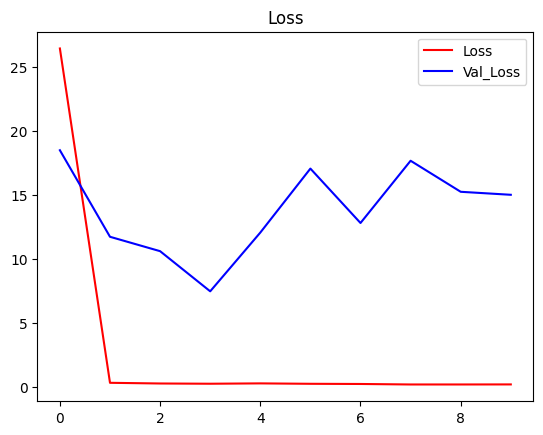

In [28]:
# plot loss 
# mean error across samples for each epoch (runthrough entire dataset)
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.legend(["Loss", "Val_Loss"])
plt.show()

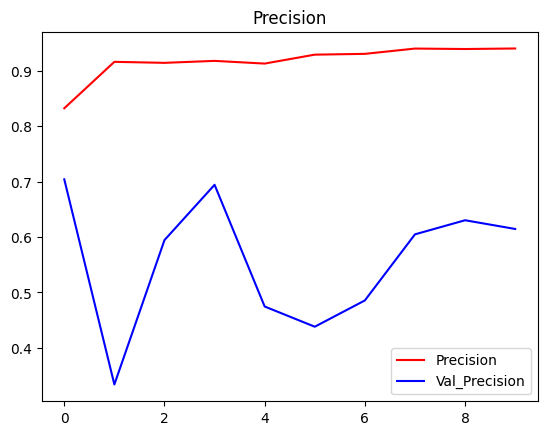

In [29]:
# plot precision
# the percent of positive predicitions that were correct (good and bad)
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.legend(["Precision", "Val_Precision"])
plt.show()

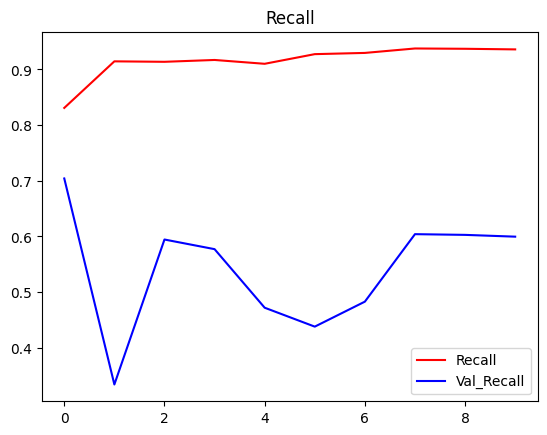

In [30]:
# plot recall
# the percentage of positive predicitions that were correct (only bad words)
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.legend(["Recall", "Val_Recall"])
plt.show()

# Make a Prediction on a Single Clip

In [65]:
# get one batch and make a prediction
X_test, y_test = test.as_numpy_iterator().next()
print(X_test.shape)
yhat = model.predict(X_test)

# Convert logits to classes
y_pred = np.argmax(yhat, axis=1)
y_pred

(16, 1084, 257, 1)
1/1 [==============================] - 0s 22ms/step


array([1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0], dtype=int64)

In [66]:
tf.math.reduce_sum(yhat)

<tf.Tensor: shape=(), dtype=float32, numpy=16.0>

In [67]:
tf.math.reduce_sum(y_test)

<tf.Tensor: shape=(), dtype=float32, numpy=16.0>

In [68]:
y_test = np.argmax(yhat, axis=1)
y_test

array([1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0], dtype=int64)

In [69]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

classes_x=np.argmax(yhat,axis=0)

cm = confusion_matrix(y_test, yhat)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes_x)
disp.plot()
plt.show()

ModuleNotFoundError: No module named 'sklearn'

# Save the Model

In [134]:
model.save('bad_mouth_2c_16n_0d_dropout_LN_5e_neg.model')
# how to load model
# new_model = tf.keras.models.load_model('bad_mouth.model')

INFO:tensorflow:Assets written to: bad_mouth_2c_16n_0d_dropout_LN_5e_neg.model\assets


INFO:tensorflow:Assets written to: bad_mouth_2c_16n_0d_dropout_LN_5e_neg.model\assets


# Convert to TF Lite

In [65]:
TF_LITE_MODEL_FILE_NAME = "bad_mouth_lite.tflite"
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tf_lite_converter.convert()
tflite_model_name = TF_LITE_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File Size: ' + str(round(size /1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File Size: ' + str(round(size /(1024*1024), 3)) + ' Megabytes')
    else:
        return print('File Size: ' + str(size) + 'bytes')

INFO:tensorflow:Assets written to: C:\Users\jreye\AppData\Local\Temp\tmpo7l7g3mg\assets


INFO:tensorflow:Assets written to: C:\Users\jreye\AppData\Local\Temp\tmpo7l7g3mg\assets


In [66]:
# check input tensor shape
convert_bytes(get_file_size(TF_LITE_MODEL_FILE_NAME), "MB")

File Size: 1.041 Megabytes
